In [57]:
import numpy as np
from typing import Iterable, Set, Tuple, List
from itertools import combinations
from math import inf

In [58]:
#unavaliable slots
#Assume slots:(start_time, end_time, bandwidth)
unavailable_slots = {(5, 10, 5),(15, 20, 10),(25, 30, 13)}
total_slots = {(0, 35, 15)}
# Assume r: (start_time. end_time, bandwidth)
inserted_r = [(3,9,1),(5,9,11),(0,3,16),(10,15,12),(11,15,4)]

In [59]:
Rect1D   = Tuple[int, int, int]          # only consider time difference
Rect2D   = Tuple[int, int, int, int]     # considering bandwidth and time difference
Slots1D  = Iterable[Rect1D]
Slots2D  = Set[Rect2D]
# result (start_time, end_time, bandwidth_lower_bound, bandwidth_higher_bound)
def get_next_slot(unavailable: Slots1D, total: Slots1D) -> Slots2D:
    res: Slots2D = set()

    for t_x1, t_x2, t_h in total:
        y_breaks = {0, t_h}
        y_breaks.update(uh for _, _, uh in unavailable if uh < t_h)
        y_sorted = sorted(y_breaks)

        for idx, y1 in enumerate(y_sorted[:-1]):
            next_y  = y_sorted[idx + 1]
            last_y  = y_sorted[-1]

            for y2 in (next_y, last_y):
                if y2 <= y1:
                    continue

                x2_limit = t_x2
                for u_x1, _, u_h in sorted(unavailable, key=lambda u: u[0]):
                    if u_h > y1 and u_x1 < x2_limit:
                        x2_limit = u_x1
                        break

                res.add((t_x1, x2_limit, y1, y2))

    return sorted(res,key=lambda r: (r[2], r[0], -r[3],r[1]))

In [60]:
print(get_next_slot(unavailable_slots, total_slots))
# unavailable_slots = {(5, 10, 5),(15, 20, 10),(23, 27, 13)}

[(0, 5, 0, 15), (0, 5, 0, 5), (0, 15, 5, 15), (0, 15, 5, 10), (0, 25, 10, 15), (0, 25, 10, 13), (0, 35, 13, 15)]


In [61]:
# Get available slots area
def compute_slot_areas(slots: List[Rect2D]) -> List[int]:
    return [(x2 - x1) * (y2 - y1) for x1, x2, y1, y2 in slots]

slot_area = compute_slot_areas(get_next_slot(unavailable_slots, total_slots))
slot_area

[75, 25, 150, 75, 125, 75, 70]

In [62]:
# Get r area
# Assume r: (start_time. end_time, bandwidth)
# Area = (end_time - start_time)* bandwidth
# before sorted, area result: r = {(x, 1),(y, 2)...,(j, n)}
# inserted_r = {(3,9,17),(5,9,11),(0,3,10),(10,15,12)}
# sorted by area
def r_sorted_by_area(r_seq, reverse=False):
    r_list = list(r_seq)
    area_with_index = [((end - start) * bw, idx + 1)
                       for idx, (start, end, bw) in enumerate(r_list)]
    area_with_index.sort(key=lambda x: x[0], reverse=reverse)
    return area_with_index

In [63]:
area_list = r_sorted_by_area(inserted_r)
area_list

[(6, 1), (16, 5), (44, 2), (48, 3), (60, 4)]

In [64]:
# for the print_out
def ordinal(n):
    return f"{n}{'st' if n==1 else 'nd' if n==2 else 'rd' if n==3 else 'th'}"
    return 0

In [65]:
def find_r_slot_with_allocation(r_list, slot_area_list, slot_area):
    """
    Step 1: compare r_list.sum with the first element of slot_area_list
    If r_list.sum < first element of slot_area_list, return("fitted in the first area"). If not, go to step 2

    Step 2: find the group of r_area best fit the second element of slot_area_list
    print out the r_area group, and note them in the second element of slot_area_list
    drop these r_area from the r_list

    Step 3: compare the rest of r_list.sum with the next element of slot_area_list
    If the rest r_list.sum < first element of slot_area_list, return("fitted in the third area"). If not, go to step 4

    Step 4: continue doing what step 2 did, but with the next element of slot_area_list after step 3

    Step 5: continue doing step 3, 4, but update with return message "fitted in the fifth/seventh/... area". Until there is no element in r_list

    :param r_list: [(area, which r),...] sorted by area
    :param slot_area_list: [area, ...] next avaliable slot
    :param slot_area: [(x1,x2,y1,y2),...], list get from get_next_slot()
    :return:
    """
    result = []
    r_remaining = r_list[:]
    allocation = []
    wasted = []

    total_r = sum(area for area, _ in r_remaining)
    even_slots_sum = sum(slot_area_list[i] for i in range(1, len(slot_area_list) - 1, 2)) if len(slot_area_list) > 1 else 0
    last_slot_area = slot_area_list[-1] if slot_area_list else 0
    if total_r > even_slots_sum + last_slot_area:
        return ["need extend space"], allocation, wasted

    slot_index = 1
    i = 0
    compare_mode = True

    while r_remaining and i < len(slot_area_list):
        current_slot_area = slot_area_list[i]
        current_slot_rect = slot_area[i]
        r_sum = sum(area for area, _ in r_remaining)

        if compare_mode:
            if r_sum <= current_slot_area:
                result.append(f"All remaining requests {r_remaining} fitted in the {ordinal(slot_index)} area")
                x1, x2, y1, y2 = current_slot_rect
                width = x2 - x1
                y_cursor = y1
                for area, rid in r_remaining:
                    h = area / width
                    allocation.append((x1, x2, y_cursor, y_cursor + h, rid))
                    y_cursor += h
                blank_h = y2 - y_cursor
                if blank_h > 0:
                    wasted.append((x1, x2, y_cursor, y2))
                return result, allocation, wasted
            i += 1
            slot_index += 1
            compare_mode = False
            continue
            # if r_sum > current_slot，then switch to next slot，find the group of r_area best fit
        """
        best_fit_r_group:
            如果找出来的r_area的集合 = current_slot
            return 这个集合
            如果找出来的这个集合的area小于current_slot，将这个集合命名为group1：
                find a r set just larger than current_slot: group2
                current_slot(x2-x1): current_slot的宽度,用slot_area这个list
                if:(group2_area - current_slot)/current_slot(x2-x1) > (next_slot(y2) - next_next_slot(y2))
                    best_fit_r_group =  group 1
                elif:
                    get ：current_slot - group1_area: blank_1
                current_slot(x2) - next_slot(x2): width
                ((group2_area - current_slot)/current_slot(x2-x1))* (current_slot(x2) - next_slot(x2)): blank_2
                compare blank_2 and blank_1
                    if blank_1 < blank_2,
                        best_fit_r_group = group 1
                    if blank_2 > current_slot,
                        leave current slot blank
                    elif blank_1 > blank_2,
                        best_fit_r_group = group 2
        IF best_fit_r_group = group 2:
            next_slot & next_next_slot height both need to - (group2_area - current_slot)/current_slot(x2-x1)
        """
        best_under, best_under_sum = (), 0
        best_over, best_over_sum = (), inf

        for n in range(1, len(r_remaining) + 1):
            for combo in combinations(r_remaining, n):
                s = sum(area for area, _ in combo)
                if s <= current_slot_area:
                    if s > best_under_sum:
                        best_under, best_under_sum = combo, s
                    if best_under_sum == current_slot_area:
                        break
                else:
                    if s < best_over_sum:
                        best_over, best_over_sum = combo, s
            if best_under_sum == current_slot_area:
                break

        blank_1 = (current_slot_area - best_under_sum) if best_under else inf
        blank_2 = inf
        if best_over and i + 1 < len(slot_area):
            x1, x2, y1, y2 = current_slot_rect
            width = x2 - x1
            slot_x2 = x2
            next_slot_x2 = slot_area[i + 1][1]
            blank_2 = ((best_over_sum - current_slot_area) / width) * abs(next_slot_x2 - slot_x2)

        if best_under and (len(best_under) > 1 or best_under_sum >= 0.8 * current_slot_area):
            best_fit_group = best_under
        elif best_over and blank_2 < current_slot_area:
            best_fit_group = best_over
        else:
            result.append(f"No requests fit in the {ordinal(slot_index)} area")
            i += 1
            slot_index += 1
            compare_mode = True
            continue

        if not best_fit_group:
            result.append(f"No requests fit in the {ordinal(slot_index)} area")
        else:
            result.append(f"Requests {list(best_fit_group)} fitted in the {ordinal(slot_index)} area")
            x1, x2, y1, y2 = current_slot_rect
            width = x2 - x1
            y_cursor = y1
            for area, rid in best_fit_group:
                h = area / width
                allocation.append((x1, x2, y_cursor, y_cursor + h, rid))
                y_cursor += h
            if y_cursor < y2:
                wasted.append((x1, x2, y_cursor, y2))
            for val in best_fit_group:
                r_remaining.remove(val)

        if best_fit_group == best_over and i + 1 < len(slot_area):
            x1, x2, y1, y2 = current_slot_rect
            delta_h = (best_over_sum - current_slot_area) / (x2 - x1)
            for j in (i + 1, i + 2):
                if j >= len(slot_area):
                    break
                xx1, xx2, yy1, yy2 = slot_area[j]
                new_y2 = yy2 - delta_h
                if new_y2 <= yy1:
                    slot_area.pop(j)
                    slot_area_list.pop(j)
                else:
                    slot_area[j] = (xx1, xx2, yy1, new_y2)
            slot_area_list[:] = [(x2 - x1) * (y2 - y1) for x1, x2, y1, y2 in slot_area]

        i += 1
        slot_index += 1
        compare_mode = True

    if r_remaining:
        result.append(f"These requests fit in the last area: {r_remaining}")
        x1, x2, y1, y2 = slot_area[-1]
        width = x2 - x1
        y_cursor = y1
        for area, rid in r_remaining:
            h = area / width
            allocation.append((x1, x2, y_cursor, y_cursor + h, rid))
            y_cursor += h
        if y_cursor < y2:
            wasted.append((x1, x2, y_cursor, y2))

    return result, allocation, wasted


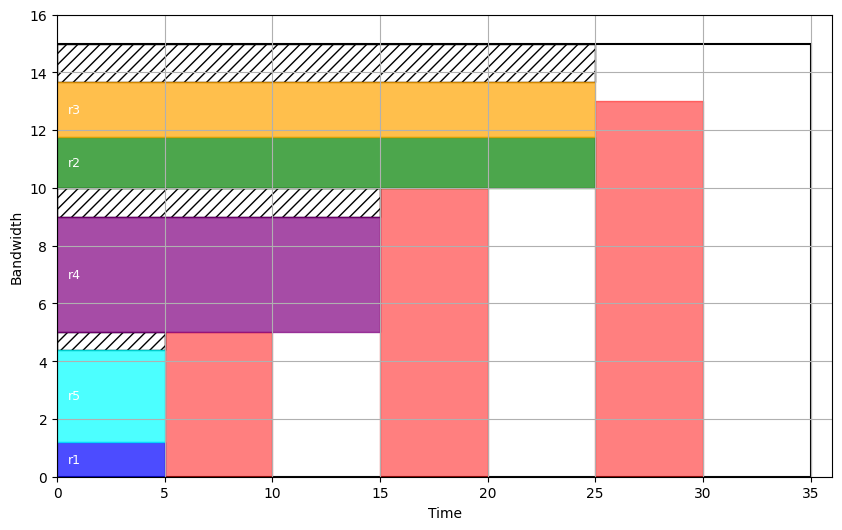

(None,
 ['Requests [(6, 1), (16, 5)] fitted in the 2nd area',
  'Requests [(60, 4)] fitted in the 4th area',
  'All remaining requests [(44, 2), (48, 3)] fitted in the 5th area'])

In [66]:
text_output, final_allocation, wasted_slots = find_r_slot_with_allocation(area_list, slot_area, get_next_slot(unavailable_slots, total_slots))

import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 6))

for x1, x2, h in total_slots:
    ax.add_patch(patches.Rectangle((x1, 0), x2 - x1, h, fill=False, edgecolor='black', linewidth=1.5))

for x1, x2, h in unavailable_slots:
    ax.add_patch(patches.Rectangle((x1, 0), x2 - x1, h, color='red', alpha=0.5, label="unavailable"))

for x1, x2, y1, y2 in wasted_slots:
    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor='black', hatch='///', linewidth=1))

colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

for x1, x2, y1, y2, rid in final_allocation:
    color = colors[(rid - 1) % len(colors)]
    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, color=color, alpha=0.7))
    ax.text(x1 + 0.5, (y1 + y2) / 2, f"r{rid}", fontsize=9, va='center', ha='left', color='white')

ax.set_xlim(0, 36)
ax.set_ylim(0, 16)
ax.set_xlabel("Time")
ax.set_ylabel("Bandwidth")
plt.grid(True)
plt.show(), text_output